In [3]:
import pandas as pd
import numpy as np
import random

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
import geopy.distance
from tqdm.notebook import tqdm

import  matplotlib.pyplot as plt

In [4]:
from scipy import stats
import statsmodels.api as sm
from itertools import product
from statsmodels.iolib.table import SimpleTable

In [5]:
SEED = 2022
device = "cuda" if torch.cuda.is_available else "cpu"
data_path = r"/content/drive/MyDrive/Семестр 3/Ml_in_da_hood/OneDrive_1_23.10.2022/train_data.csv"
valid_path = r"/content/drive/MyDrive/Семестр 3/Ml_in_da_hood/OneDrive_1_23.10.2022/valid.csv"

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Чтение данных

In [7]:
data = pd.read_csv(data_path)
valid = pd.read_csv(valid_path)

### Обработка данных

In [39]:
df = data.copy().drop(["likescount",	"commentscount",	"symbols_cnt",	"words_cnt",	"hashtags_cnt",	"mentions_cnt",	"links_cnt",	"emoji_cnt"], axis=1)
df = df[(df.lat>59) & (df.lon>29) & (df.lon<31)].reset_index(drop=True)
df["cnt"] = 1

df_global_group = pd.DataFrame(df.groupby(['point'], as_index=False).cnt.sum())
df_global_group = df_global_group[df_global_group.cnt > 365*1.5]

df_group = df[df.point.isin(df_global_group["point"])].groupby(["lon", "lat", "timestamp", "point"], as_index=False).cnt.sum()

In [41]:
print(df_group.shape)
df_group.head()

(3137789, 5)


,lon,lat,timestamp,point,cnt
0,30.093562,59.853756,1546498800,0101000020E61000008D792FAEF3173E40717466E047ED...,1
1,30.093562,59.853756,1546520400,0101000020E61000008D792FAEF3173E40717466E047ED...,1
2,30.093562,59.853756,1546693200,0101000020E61000008D792FAEF3173E40717466E047ED...,1
3,30.093562,59.853756,1546761600,0101000020E61000008D792FAEF3173E40717466E047ED...,1
4,30.093562,59.853756,1546783200,0101000020E61000008D792FAEF3173E40717466E047ED...,1


### Заполнение отсутствующих значений

In [45]:
df_group_all = pd.DataFrame()
place_arr = df_group["point"].unique().tolist()
for _, place in tqdm(enumerate(place_arr)):
    
    one_point =  df_group[df_group["point"] == place]
    timestamps_list = list(range(min(one_point['timestamp']), max(one_point['timestamp'])+3600, 3600))

    df_tmp = pd.DataFrame()
    df_tmp['timestamp'] = timestamps_list
    df_tmp = pd.merge(df_tmp, one_point, how="left", on="timestamp")
    df_tmp['point'] = df_tmp["point"][0]
    df_tmp['lat'] = df_tmp["lat"][0]
    df_tmp['lon'] = df_tmp["lon"][0]
    df_tmp = df_tmp.fillna(0)

    df_group_all = pd.concat([df_group_all, df_tmp], ignore_index=True)

0it [00:00, ?it/s]

In [48]:
print(df_group_all.shape)
df_group_all.head()

(13935147, 5)


,timestamp,lon,lat,point,cnt
0,1546498800,30.093562,59.853756,0101000020E61000008D792FAEF3173E40717466E047ED...,1.0
1,1546502400,30.093562,59.853756,0101000020E61000008D792FAEF3173E40717466E047ED...,0.0
2,1546506000,30.093562,59.853756,0101000020E61000008D792FAEF3173E40717466E047ED...,0.0
3,1546509600,30.093562,59.853756,0101000020E61000008D792FAEF3173E40717466E047ED...,0.0
4,1546513200,30.093562,59.853756,0101000020E61000008D792FAEF3173E40717466E047ED...,0.0


In [47]:
df_group_all.to_csv(r"/content/drive/MyDrive/Семестр 3/Ml_in_da_hood/all_data.csv", index=False)

In [8]:
df_group_all = pd.read_csv(r"/content/drive/MyDrive/Семестр 3/Ml_in_da_hood/all_data.csv")

In [10]:
df_group_all = df_group_all.sort_values(["point", "timestamp"])

In [12]:
import numpy as np
import tensorflow
from tensorflow.keras import Input
from tensorflow.keras import Model
import keras

from tensorflow.keras.layers import Dense, concatenate
from tensorflow.keras.layers import LSTM

In [17]:
def sampling(sequence, n_steps):
  sequence = sequence.tolist()
  X, Y = list(), list()

  for i in range(len(sequence)):

    sam = i + n_steps
    if sam > len(sequence)-1:
      break

    x, y = sequence[i:sam], sequence[sam]

    X.append(x)

    Y.append([y])

  return np.array(X), np.array(Y)


def fit_lstm(X, y, nb_epoch, n_neurons, additional=[], experts = [],n_batch=1):
    #n_batch=1
    tensorflow.keras.utils.set_random_seed(42)
    in1 = Input(batch_shape = (n_batch, X.shape[1], X.shape[2]))
    out1 = LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True, return_sequences=False, activation='relu')(in1)
    out1 = Dense(50, activation='relu')(out1)
    if len(additional):
        if len(experts):
            add_input = additional #.reshape(additional.shape[0], additional.shape[1])
            in2 = Input(batch_shape = (n_batch, add_input.shape[1]))
            out2 = Dense(add_input.shape[1], activation='relu')(in2)
            out2 = Dense(50, activation='relu')(out2)

            exp_input = experts
            experts_input = experts #.reshape(additional.shape[0], additional.shape[1])
            in2_exp = Input(batch_shape = (n_batch, experts_input.shape[1]))
            out3 = Dense(experts_input.shape[1], activation='relu')(in2_exp)
            out3 = Dense(50, activation='relu')(out3)
            

            x = concatenate([out1, out2, out3]) 
            x = Dense(y.shape[1], activation='linear')(x)
            model = Model(inputs=[in1,in2,in2_exp], outputs=x)
            fitdat=[X,add_input,exp_input]
        else:
            add_input = additional #.reshape(additional.shape[0], additional.shape[1])
            in2 = Input(batch_shape = (n_batch, add_input.shape[1]))
            out2 = Dense(add_input.shape[1], activation='relu')(in2)
            out2 = Dense(50, activation='relu')(out2)
            x = concatenate([out1, out2]) 
            x = Dense(y.shape[1], activation='linear')(x)
            model = Model(inputs=[in1,in2], outputs=x)
            fitdat=[X,add_input]

    else:
        x = Dense(y.shape[1], activation='linear')(out1)
        model = Model(inputs=[in1], outputs=x)
        fitdat=[X]
    opt = keras.optimizers.Adam(learning_rate=0.00001)
    model.compile(loss='mean_squared_error',metrics=['mape'], optimizer='adamax',  run_eagerly=True)
    history_loss=[]
    history_val_loss=[]
    for i in range(nb_epoch):
        hist = model.fit(fitdat, y, validation_split=0.1,epochs=1, batch_size=n_batch, verbose=1, shuffle=False)
        history_loss.append(hist.history['loss'])
        history_val_loss.append(hist.history['val_loss'])
    #print(model.summary())
    return model,history_loss,history_val_loss



def make_forecast(model, train_df, lag, fwd):
    zfwd=np.array([])
    trg=train_df['cnt'][-(lag +1):].values
    for i in range(fwd):
        X, y = sampling(trg, lag)
        X.shape
        inp=[X[:1]]
        inp[0].shape
        z=model.predict(inp, verbose=0)[0]
        zfwd=np.concatenate((zfwd, z))
        trg=np.concatenate((trg[1:], z))
    return zfwd


def normalize(x):
    mi=np.nanmin(x)
    ma=np.nanmax(np.array(x)-mi)
    if ma>0.:
        x_n=(np.array(x)-mi)/ma
        return x_n, mi, ma
    else:
        return np.zeros(len(x)), mi, ma

def un_normalize(x_n, mi, ma):
    return x_n*ma+mi

In [18]:
poly_test = valid['point'].unique().tolist()[0]
train_df = df_group_all[df_group_all['point'] == poly_test]

In [19]:
train_df = train_df[-200:]
train_df['norm'], mi, ma = normalize(train_df['cnt'])
lag = 48
X, y = sampling(train_df['norm'], lag)
X = np.expand_dims(X,2)
X.shape, y.shape
model2,history_loss2,history_val_loss = fit_lstm(X, y, 5, 50 ,n_batch = 1)


136/136 [==============================] - 19s 140ms/step - loss: 0.0263 - mape: 27262654.0000 - val_loss: 0.0390 - val_mape: 68.2514


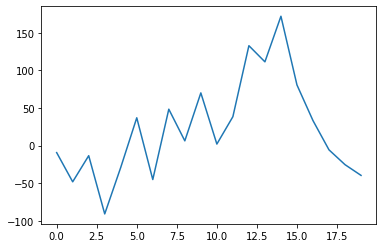

In [20]:
test_df = valid[valid['point'] == poly_test].sort_values(by=['hour'])
last_train = max(train_df['timestamp'])
last_test = max(test_df['hour'])
dates_to_pred = list(range(last_train+3600,last_test+3600, 3600))
#fwd = len(dates_to_pred)
fwd = 20
zfwd = make_forecast(model2, train_df,lag, fwd)
zfwd = un_normalize(zfwd, mi, ma)
plt.plot(zfwd)